<img src='../data/imgs/udesa_logo.png'>

<h1> Notebook de analisis de todos los modelos

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils_dataset import get_val_dataset_and_loader
from analisis import plot_gradcam_indices, extract_features, compare_gradcam_models, get_metrics
from sklearn.metrics import confusion_matrix, classification_report

<h4> Cargo el dataset de validacion con sus respectivas transformaciones

In [2]:
val_dataset, val_loader = get_val_dataset_and_loader(
    csv_file="../data/stanford_cars/labels_val.csv",
    img_dir="../data/stanford_cars/validation"
)

<h4> Bajo los modelos con sus respectivos pesos

In [3]:
num_classes = 49

model_resnet18 = models.resnet18(weights=None)
model_resnet18.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model_resnet18.fc.in_features, num_classes)
)
model_resnet18.load_state_dict(torch.load("../pesos/resnet18_best.pth", map_location="cpu"))

model_alexnet = models.alexnet(weights=None)
model_alexnet.classifier[6] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model_alexnet.classifier[6].in_features, num_classes)
)
model_alexnet.load_state_dict(torch.load("../pesos/alexnet_best.pth", map_location="cpu"))

model_resnet50 = models.resnet50(weights=None)
model_resnet50.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model_resnet50.fc.in_features, num_classes)
)
model_resnet50.load_state_dict(torch.load("../pesos/resnet50_best_copy.pth", map_location="cpu"))

<All keys matched successfully>

In [4]:
# Simple CNN (tipo VGG pequeña)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, img_size=128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.2),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.4),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instanciar y cargar pesos
num_classes = 49  # o el número correcto de clases
model = SimpleCNN(num_classes=num_classes, img_size=128).to("cpu")
model.load_state_dict(torch.load("../pesos/simplecnn_best.pth", map_location="cpu"))
model = model.to("cpu")
model.eval()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, inplace

<h4> Bajo tambien las etiquetas y las predicicones de cada uno de los modelos para el conjunto de validacion

In [7]:
data_alexnet = np.load("../data/pred/predicciones_alexnet.npz")
alex_preds = data_alexnet["preds"]
alex_labels = data_alexnet["labels"]

data_resnet18 = np.load("../data/pred/predicciones_resnet18.npz")
resnet18_preds = data_resnet18["preds"]
resnet18_labels = data_resnet18["labels"]

data_resnet50 = np.load("../data/pred/predicciones_resnet50.npz")
resnet50_preds = data_resnet50["preds"]
resnet50_labels = data_resnet50["labels"]

data_simplecnn = np.load("../data/pred/predicciones_cnn.npz")
simplecnn_preds = data_simplecnn["preds"]
simplecnn_labels = data_simplecnn["labels"]

<h2> Analisis cuantitiativo

En primer lugar queremos hacer un analisis tradicional, cualititvio para ver los resultados generales de los modelos. Para esto vamos a ver metricas generales como la accuracy, precision, recall y f1-score. Como ver las matrices de confusion y curvas de entrenaimenot y validacion iba a verse muy repetitivo, decidmos dejarlas en sus respectivos notebooks.

De las curvas de entrenamiento podemos ver que el modelo converge y no hay overfitting, lo cual es bueno.

In [8]:


metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'ResNet18': get_metrics(resnet18_labels, resnet18_preds),
    'ResNet50': get_metrics(resnet50_labels, resnet50_preds),
    'AlexNet': get_metrics(alex_labels, alex_preds),
    'SimpleCNN': get_metrics(simplecnn_labels, simplecnn_preds)

})

metrics_df[['ResNet18', 'ResNet50', 'AlexNet', 'SimpleCNN']] = metrics_df[['ResNet18', 'ResNet50', 'AlexNet', 'SimpleCNN']].round(2)
display(metrics_df)

,Metric,ResNet18,ResNet50,AlexNet,SimpleCNN
0,Accuracy,0.78,0.82,0.42,0.11
1,Precision,0.79,0.83,0.44,0.03
2,Recall,0.78,0.82,0.42,0.11
3,F1-score,0.78,0.82,0.42,0.03


<h2> Analisis cualitativo de las predicciones

Esta parte es un analisi mas enfocado a como son los resultados de las preddicones en si mas alla de si estan bien o mal, sino que queremos ver como se comporta el modelo en las diferentes clases, y como se comporta en las diferentes imagenes.

Luego, vamos a aplicar el algoritmo de Grad-CAM para ver que regiones de la imagen son las que el modelo esta usando para hacer sus predicciones.

c:\Users\03tom\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


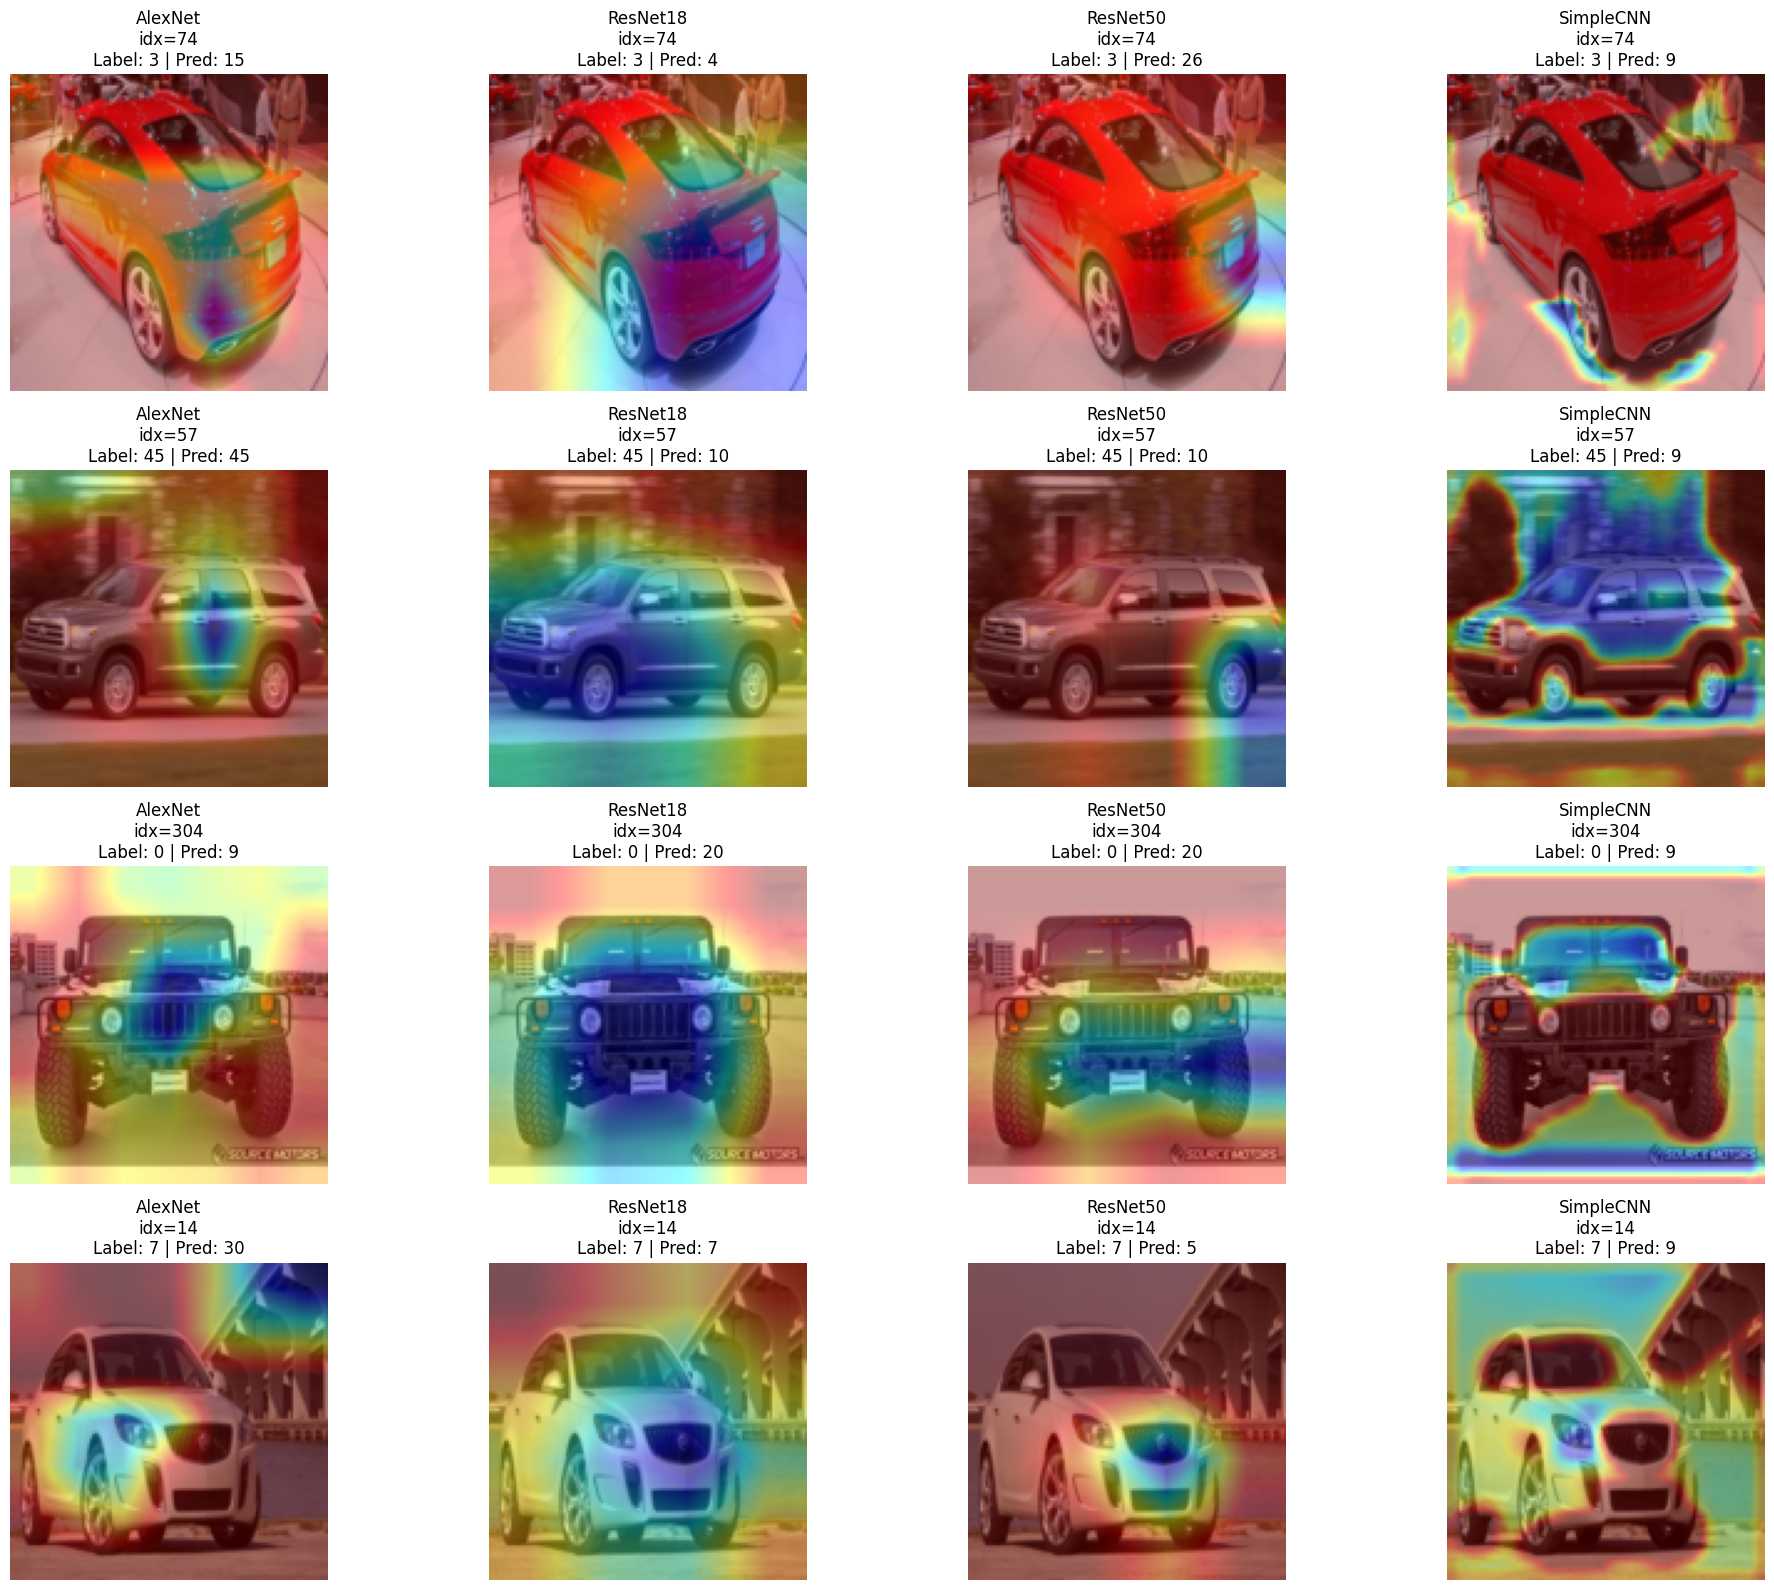

In [9]:
compare_gradcam_models(
    models=[model_alexnet, model_resnet18, model_resnet50, model],
    model_names=["AlexNet", "ResNet18", "ResNet50", "SimpleCNN"],
    dataset=val_dataset,
    indices=[74, 57, 304, 14],
    layer_names=['features.10', 'layer4', 'layer4', 'features.19']  # OJO, si cambian chequen de poner bien
)

Este tipo de analisis nos es muy enriquecedor porque podemos ver variso casos, por ejemplo, en primer lugar vemos que donde fallan nuestros mejores modelos es en las imagenes de autos mirando para atras, y tambien podemos ver que los patrones que estan aprendiendo la alexnet a diferencia de ambas resnet (18 y 50) en este caso son muy difernetes, y a su vez distintos de los de la CNN.

En general, podemos ver que la resnet18 no enfoca tanto en parte especificas del auto, sino que se enfoca en el auto en general, mientras que la resnet50 si se enfoca en partes especificas del auto.Por su parte, la alexnet se enfoca en patrones mas generales. La alexnet va variando de comportamiento asi que no podemos sacar una conclusion general del modelo.

Podemos ver que el modelo simplecnn no caputra relaciones interesantes y dentro de todo es un modelo de bajo rendimiento, por lo tanto no nos puede aportar mucho al analisis.

Por utlimo, queremos ver un poco las caractersiticas que extrajo para cada clase en baja dimensionalidad, para ver como se agrupan las caracteriticas de las diferentes clases, y ver si se logran separar bien y hay clusters bien definidos, o si hay clases que se mezclan entre si.

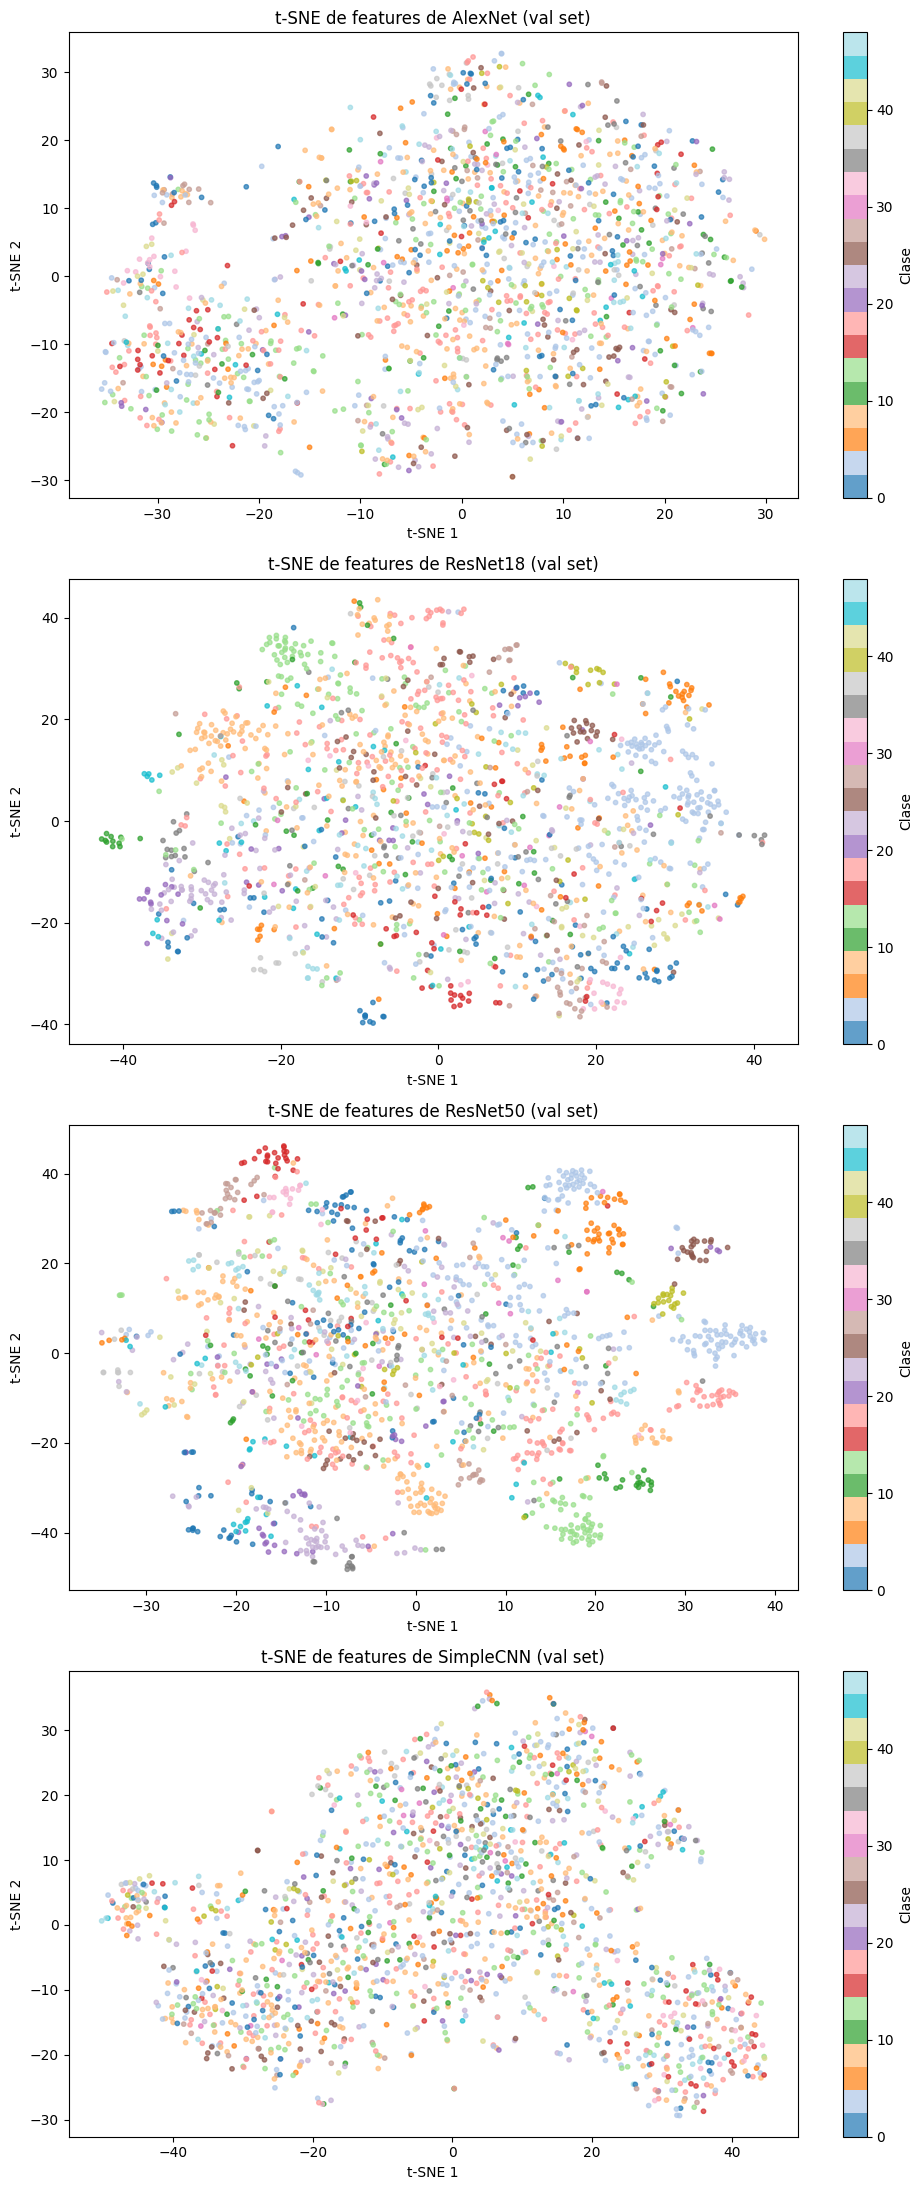

In [10]:
# Extraigo features y labels de la penúltima capa (antes de clasificar) para los tres modelos
features_alex, labels_alex = extract_features(model_alexnet, val_loader)
features_res18, labels_res18 = extract_features(model_resnet18, val_loader)
features_res50, labels_res50 = extract_features(model_resnet50, val_loader)
features_simplecnn, labels_simplecnn = extract_features(model, val_loader)

# t-SNE para cada modelo
tsne_alex = TSNE(n_components=2, random_state=42, perplexity=30)
features2d_alex = tsne_alex.fit_transform(features_alex)

tsne_res18 = TSNE(n_components=2, random_state=42, perplexity=30)
features2d_res18 = tsne_res18.fit_transform(features_res18)

tsne_res50 = TSNE(n_components=2, random_state=42, perplexity=30)
features2d_res50 = tsne_res50.fit_transform(features_res50)

tsne_simplecnn = TSNE(n_components=2, random_state=42, perplexity=30)
features2d_simplecnn = tsne_simplecnn.fit_transform(features_simplecnn)

# Graficar los tres t-SNE uno debajo del otro
fig, axes = plt.subplots(4, 1, figsize=(10, 22))

scatter0 = axes[0].scatter(features2d_alex[:, 0], features2d_alex[:, 1], c=labels_alex, cmap='tab20', s=10, alpha=0.7)
axes[0].set_title("t-SNE de features de AlexNet (val set)")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
plt.colorbar(scatter0, ax=axes[0], label='Clase')

scatter1 = axes[1].scatter(features2d_res18[:, 0], features2d_res18[:, 1], c=labels_res18, cmap='tab20', s=10, alpha=0.7)
axes[1].set_title("t-SNE de features de ResNet18 (val set)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
plt.colorbar(scatter1, ax=axes[1], label='Clase')

scatter2 = axes[2].scatter(features2d_res50[:, 0], features2d_res50[:, 1], c=labels_res50, cmap='tab20', s=10, alpha=0.7)
axes[2].set_title("t-SNE de features de ResNet50 (val set)")
axes[2].set_xlabel("t-SNE 1")
axes[2].set_ylabel("t-SNE 2")
plt.colorbar(scatter2, ax=axes[2], label='Clase')

scatter3 = axes[3].scatter(features2d_simplecnn[:, 0], features2d_simplecnn[:, 1], c=labels_simplecnn, cmap='tab20', s=10, alpha=0.7)
axes[3].set_title("t-SNE de features de SimpleCNN (val set)")
axes[3].set_xlabel("t-SNE 1")
axes[3].set_ylabel("t-SNE 2")
plt.colorbar(scatter3, ax=axes[3], label='Clase')

plt.tight_layout()
plt.show()

NOTA: Tanto estos graficos de tsne como los de grad-cam pueden verse afectados en uno o mas modelos ya que se bajo la escala para poder hacerlo compatible con el modelo de CNN, por tanto, si bien son parecidos decidimos tomar sus otroas versiones que decriben mejor en ambos casos.

Podemos ver que a medida que los modelos tienen mejores metricas generales, pdoemos ver clusters mas definidos y separados entre si, lo cual es una buena señal de que el modelo esta aprendiendo bien las caracteristicas de cada clase y no esta mezclando clases entre si.

Tambein podemos notar una transicion; pasamos de no tener clusters defindos (en alexnet o simplecnn), a tener clusters un poco definidos mas alejados del centro en resnet 18, y clusters mas definidos y separados en resnet 50, lo cual es una buena señal de que el modelo esta aprendiendo bien las caracteristicas de cada clase y no esta mezclando clases entre si.